# Clustering Wrangle Lesson

<hr style="border:2px solid gray">

<div class="alert alert-block alert-danger">
 <div class="row vertical-align">
            <i class="fa fa-exclamation-triangle fa-2x"></i>
<b>Reminder:</b> Be sure to push .gitignore file prior to adding the env.py
</div>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import env

In [2]:
sql_query = '''
    SELECT * 
    from passengers;
    '''

In [3]:
def get_titanic_data():
    '''
    This function uses a SQL query 
    and get_connection function from the envy.py file
    to create and dataframe of mall data
    it then drops the id column and returns the clean dataframe
    '''    
    df = pd.read_sql(sql_query, env.get_connection('titanic_db'))
    
    return df

In [4]:
#assign variable to our function
df = get_titanic_data()

#take a look
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,None,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,None,Southampton,1


<hr style="border:2px solid black">

## Dive into the data

In [5]:
#descriptive stats for our numeric columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
passenger_id,891.0,445.000000,257.353842,0.00,222.5000,445.0000,667.5,890.0000
survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
sibsp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292
alone,891.0,0.602694,0.489615,0.00,0.0000,1.0000,1.0,1.0000


In [6]:
#how many rows and columns do we have
print(f'rows: {df.shape[0]}')
print(f'co1umns: {df.shape[1]}')

rows: 891
co1umns: 13


In [7]:
#what columns do we have
df.columns.to_list()

['passenger_id',
 'survived',
 'pclass',
 'sex',
 'age',
 'sibsp',
 'parch',
 'fare',
 'embarked',
 'class',
 'deck',
 'embark_town',
 'alone']

In [8]:
#what repetative columns do we have?
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,None,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,None,Southampton,1


In [9]:
#drop some repetative columns- pclass and class are the same, embark_town and embarked are the same
df = df.drop(columns = ['class', 'embark_town'])

In [10]:
#make sure those columns have been dropped
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,deck,alone
0,0,0,3,male,22.0,1,0,7.2500,S,None,0
1,1,1,1,female,38.0,1,0,71.2833,C,C,0
2,2,1,3,female,26.0,0,0,7.9250,S,None,1
3,3,1,1,female,35.0,1,0,53.1000,S,C,0
4,4,0,3,male,35.0,0,0,8.0500,S,None,1


<hr style="border:2px solid black">

# Nulls by column

In [11]:
#again, how many rows are we working with?
print(f'rows: {df.shape[0]}')

rows: 891


In [12]:
#take a look at our nulls
df.isnull().sum()

passenger_id      0
survived          0
pclass            0
sex               0
age             177
sibsp             0
parch             0
fare              0
embarked          2
deck            688
alone             0
dtype: int64

In [13]:
#what percent of those rows are null for each feature
(df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False)

deck            77.216611
age             19.865320
embarked         0.224467
passenger_id     0.000000
survived         0.000000
pclass           0.000000
sex              0.000000
sibsp            0.000000
parch            0.000000
fare             0.000000
alone            0.000000
dtype: float64

<div class="alert alert-block alert-info">
<b>Note:</b> 
We can now see that 77% of the deck column is null as is almost 20% of the age column

<hr style="border:2px solid black">

## Create functions to detect and count outliers

In [39]:
def outlier_function(df, cols, k):
    '''
    This function takes in a dataframe, column, and k
    to detect and handle outlier using IQR rule
    '''
    for col in df[cols]:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_bound =  q3 + k * iqr
        lower_bound =  q1 - k * iqr     
        df = df[(df[col] < upper_bound) & (df[col] > lower_bound)]
    return df

In [15]:
def nulls_by_col(df):
    '''
    This function takes in a dataframe 
    and finds the number of missing values
    it returns a new dataframe with quantity and percent of missing values
    '''
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    percent_missing = num_missing / rows * 100
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'percent_rows_missing': percent_missing})
    return cols_missing.sort_values(by='num_rows_missing', ascending=False)

In [16]:
#use our new function
nulls_by_col(df)

,num_rows_missing,percent_rows_missing
deck,688,77.216611
age,177,19.865320
embarked,2,0.224467
passenger_id,0,0.000000
survived,0,0.000000
pclass,0,0.000000
sex,0,0.000000
sibsp,0,0.000000
parch,0,0.000000
fare,0,0.000000


## Nulls by row

In [17]:
#again, how many rows are we working with?
print(f'rows: {df.shape[0]}')

rows: 891


In [18]:
#and number of columns
print(f'co1umns: {df.shape[1]}')

co1umns: 11


In [19]:
#do we have nulls there?
df.isnull().sum(axis=1)

0      1
1      0
2      1
3      0
4      1
      ..
886    1
887    0
888    2
889    0
890    1
Length: 891, dtype: int64

In [20]:
#what percent is this
(df.isnull().sum(axis=1)/df.shape[1]*100).sort_values(ascending=False)

502    18.181818
773    18.181818
517    18.181818
783    18.181818
359    18.181818
         ...    
659     0.000000
662     0.000000
438     0.000000
215     0.000000
445     0.000000
Length: 891, dtype: float64

In [21]:
def nulls_by_row(df):
    '''
    This function takes in a dataframe 
    and finds the number of missing values in a row
    it returns a new dataframe with quantity and percent of missing values
    '''
    num_missing = df.isnull().sum(axis=1)
    percent_miss = num_missing / df.shape[1] * 100
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': percent_miss})
    rows_missing = df.merge(rows_missing,
                        left_index=True,
                        right_index=True)[['num_cols_missing', 'percent_cols_missing']]
    return rows_missing.sort_values(by='num_cols_missing', ascending=False)

In [22]:
nulls_by_row(df)

,num_cols_missing,percent_cols_missing
502,2,18.181818
773,2,18.181818
517,2,18.181818
783,2,18.181818
359,2,18.181818
...,...,...
659,0,0.000000
662,0,0.000000
438,0,0.000000
215,0,0.000000


In [43]:
#call out the specific row that has 18% null values
print("Value of Passenger 502")
display(df.iloc[502])

Value of row 502


passenger_id                      502
survived                            0
pclass                              3
sex                            female
age                               NaN
sibsp                               0
parch                               0
fare                           7.6292
embarked                            Q
deck                             None
alone                               1
passenger_id_outliers_upper         0
survived_outliers_upper             0
pclass_outliers_upper               0
age_outliers_upper                NaN
sibsp_outliers_upper              0.0
parch_outliers_upper              0.0
fare_outliers_upper               0.0
alone_outliers_upper                0
Name: 502, dtype: object

<div class="alert alert-block alert-info">
<b>Note:</b> 
We can now see at most there are 18.2% of missing values (2 out of 11 columns)

<hr style="border:2px solid gray">

## Summary

<div class="alert alert-block alert-info">
<b>Note:</b> 
We can now turn all of this into one function that will summarize our findings.

In [23]:
def summarize(df):
    '''
    summarize will take in a single argument (a pandas dataframe) 
    and output to console various statistics on said dataframe, including:
    # .head()
    # .info()
    # .describe()
    # .value_counts()
    # observation of nulls in the dataframe
    '''
    print('SUMMARY REPORT')
    print('=====================================================\n\n')
    print('Dataframe head: ')
    print(df.head(3))
    print('=====================================================\n\n')
    print('Dataframe info: ')
    print(df.info())
    print('=====================================================\n\n')
    print('Dataframe Description: ')
    print(df.describe())
    num_cols = [col for col in df.columns if df[col].dtype != 'O']
    cat_cols = [col for col in df.columns if col not in num_cols]
    print('=====================================================')
    print('DataFrame value counts: ')
    for col in df.columns:
        if col in cat_cols:
            print(df[col].value_counts(), '\n')
        else:
            print(df[col].value_counts(bins=10, sort=False), '\n')
    print('=====================================================')
    print('nulls in dataframe by column: ')
    print(nulls_by_col(df))
    print('=====================================================')
    print('nulls in dataframe by row: ')
    print(nulls_by_row(df))
    print('=====================================================')

In [24]:
#use our function
summary = summarize(df)

SUMMARY REPORT


Dataframe head: 
   passenger_id  survived  pclass     sex   age  sibsp  parch     fare  \
0             0         0       3    male  22.0      1      0   7.2500   
1             1         1       1  female  38.0      1      0  71.2833   
2             2         1       3  female  26.0      0      0   7.9250   

  embarked  deck  alone  
0        S  None      0  
1        C     C      0  
2        S  None      1  


Dataframe info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passenger_id  891 non-null    int64  
 1   survived      891 non-null    int64  
 2   pclass        891 non-null    int64  
 3   sex           891 non-null    object 
 4   age           714 non-null    float64
 5   sibsp         891 non-null    int64  
 6   parch         891 non-null    int64  
 7   fare          891 non-null    float64
 8   embark

<hr style="border:2px solid gray">

## Now, Let's Prepare

<div class="alert alert-block alert-info">
<b>Note:</b> 
We have found all of our nulls, so now we can create functions and use them to clean up our dataframe.
</div>

In [25]:
def remove_columns(df, cols_to_remove):
    '''
    This function takes in a dataframe 
    and the columns that need to be dropped
    then returns the desired dataframe.
    '''
    df = df.drop(columns=cols_to_remove)
    return df

In [26]:
def handle_missing_values(df, prop_required_columns=0.5, prop_required_rows=0.75):
    '''
    This function takes in a dataframe, the percent of columns and rows
    that need to have values/non-nulls
    and returns the dataframe with the desired amount of nulls left.
    '''
    column_threshold = int(round(prop_required_columns * len(df.index), 0))
    df = df.dropna(axis=1, thresh=column_threshold)
    row_threshold = int(round(prop_required_rows * len(df.columns), 0))
    df = df.dropna(axis=0, thresh=row_threshold)
    return df

In [27]:
def data_prep(df, col_to_remove=[], prop_required_columns=0.5, prop_required_rows=0.75):
    '''
    This function uses two other functions to remove columns 
    and desired number of nulls values
    then returns the cleaned dataframe with acceptable number of nulls.
    '''
    df = remove_columns(df, col_to_remove)
    df = handle_missing_values(df, prop_required_columns, prop_required_rows)
    return df

In [28]:
#take a look
clean_df = data_prep(df, col_to_remove=['deck'], prop_required_columns=0.5, prop_required_rows=0.75)
clean_df.head

<bound method NDFrame.head of      passenger_id  survived  pclass     sex   age  sibsp  parch     fare  \
0               0         0       3    male  22.0      1      0   7.2500   
1               1         1       1  female  38.0      1      0  71.2833   
2               2         1       3  female  26.0      0      0   7.9250   
3               3         1       1  female  35.0      1      0  53.1000   
4               4         0       3    male  35.0      0      0   8.0500   
..            ...       ...     ...     ...   ...    ...    ...      ...   
886           886         0       2    male  27.0      0      0  13.0000   
887           887         1       1  female  19.0      0      0  30.0000   
888           888         0       3  female   NaN      1      2  23.4500   
889           889         1       1    male  26.0      0      0  30.0000   
890           890         0       3    male  32.0      0      0   7.7500   

    embarked  alone  
0          S      0  
1          C 

In [29]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passenger_id  891 non-null    int64  
 1   survived      891 non-null    int64  
 2   pclass        891 non-null    int64  
 3   sex           891 non-null    object 
 4   age           714 non-null    float64
 5   sibsp         891 non-null    int64  
 6   parch         891 non-null    int64  
 7   fare          891 non-null    float64
 8   embarked      889 non-null    object 
 9   alone         891 non-null    int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 69.7+ KB


<hr style="border:2px solid black">

<div class="alert alert-block alert-info">
    <b>Note</b>:
We have dealt with our nulls, now let's take care of the outliers</b> 
</div>

<b>The method we will be using to handle outliers for this lesson is IQR:
- <b>IQR method</b>: not contingent on normality
<br>
    
<b>Z-score</b> is another method that can be used to handle outliers for normally distributed data. We will go further into this in Anomaly Detection.
 

<b>IQR Steps</b>:
1. Get Q3 and Q1
    - using numpy's quantile function
2. Get difference (q3-q1)
3. Establish "fences":
    - Standard inner fence: k = 1.5
    - Standard outer fence: k = 3.0
    - Upper bound: q3 + k * IQR
    - Lower bound: q1 - k * IQR

In [30]:
def get_upper_outliers(s, k=1.5):
    '''
    Given a series and a cutoff value, k, returns the upper outliers for the
    series.

    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound the observation is.
    '''
    q1, q3 = s.quantile([.25, 0.75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

In [31]:
#use our function to see outliers for age
get_upper_outliers(df.fare, k=1.5)

0      0.0000
1      5.6489
2      0.0000
3      0.0000
4      0.0000
        ...  
886    0.0000
887    0.0000
888    0.0000
889    0.0000
890    0.0000
Name: fare, Length: 891, dtype: float64

In [32]:
def add_upper_outlier_columns(df, k=1.5):
    '''
    Add a column with the suffix _outliers for all the numeric columns
    in the given dataframe.
    '''
    for col in df.select_dtypes('number'):
        df[col + '_outliers_upper'] = get_upper_outliers(df[col], k)
    return df

In [33]:
#create a dataframe with the outlier columns
df_outlier = add_upper_outlier_columns(df)
df_outlier

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,deck,alone,passenger_id_outliers_upper,survived_outliers_upper,pclass_outliers_upper,age_outliers_upper,sibsp_outliers_upper,parch_outliers_upper,fare_outliers_upper,alone_outliers_upper
0,0,0,3,male,22.0,1,0,7.2500,S,None,0,0,0,0,0.0,0.0,0.0,0.0000,0
1,1,1,1,female,38.0,1,0,71.2833,C,C,0,0,0,0,0.0,0.0,0.0,5.6489,0
2,2,1,3,female,26.0,0,0,7.9250,S,None,1,0,0,0,0.0,0.0,0.0,0.0000,0
3,3,1,1,female,35.0,1,0,53.1000,S,C,0,0,0,0,0.0,0.0,0.0,0.0000,0
4,4,0,3,male,35.0,0,0,8.0500,S,None,1,0,0,0,0.0,0.0,0.0,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,886,0,2,male,27.0,0,0,13.0000,S,None,1,0,0,0,0.0,0.0,0.0,0.0000,0
887,887,1,1,female,19.0,0,0,30.0000,S,B,1,0,0,0,0.0,0.0,0.0,0.0000,0
888,888,0,3,female,NaN,1,2,23.4500,S,None,0,0,0,0,NaN,0.0,2.0,0.0000,0
889,889,1,1,male,26.0,0,0,30.0000,C,C,1,0,0,0,0.0,0.0,0.0,0.0000,0


In [34]:
outlier_cols = [col for col in df.columns if col.endswith('_outliers_upper')]
for col in outlier_cols:
    print(col, ': ')
    subset = df[col][df[col] > 0]
    print(f'Number of Observations Above Upper Bound: {subset.count()}', '\n')
    print(subset.describe())
    print('------', '\n')

passenger_id_outliers_upper : 
Number of Observations Above Upper Bound: 0 

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: passenger_id_outliers_upper, dtype: float64
------ 

survived_outliers_upper : 
Number of Observations Above Upper Bound: 0 

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: survived_outliers_upper, dtype: float64
------ 

pclass_outliers_upper : 
Number of Observations Above Upper Bound: 0 

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: pclass_outliers_upper, dtype: float64
------ 

age_outliers_upper : 
Number of Observations Above Upper Bound: 11 

count    11.000000
mean      4.960227
std       4.568171
min       0.187500
25%       0.687500
50%       5.187500
75%       6.187500
max      15.187500
Name: age_outliers_upper, dtype: float64
------ 

sibsp_outliers_upper : 
Numbe

<hr style="border:2px solid black">

## Take a look at the visuals

Histograms can be a simple way to visualize distributions, but there could be a better way..

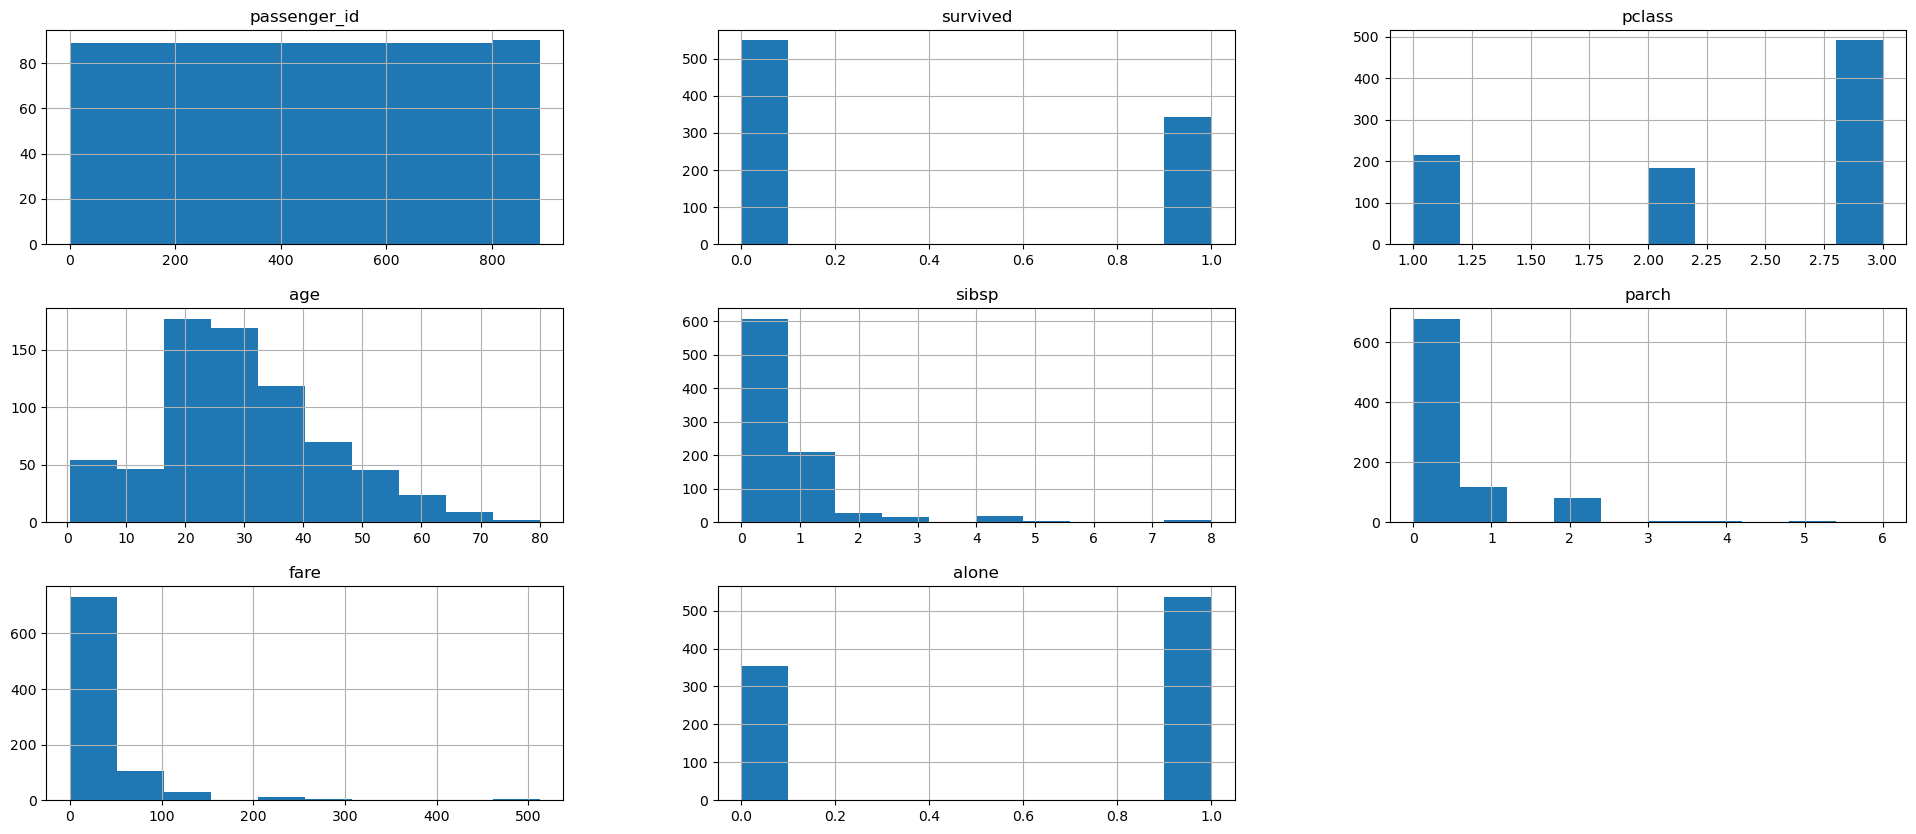

In [35]:
#take a look at all features
clean_df.hist(figsize=(24, 10))
plt.show()

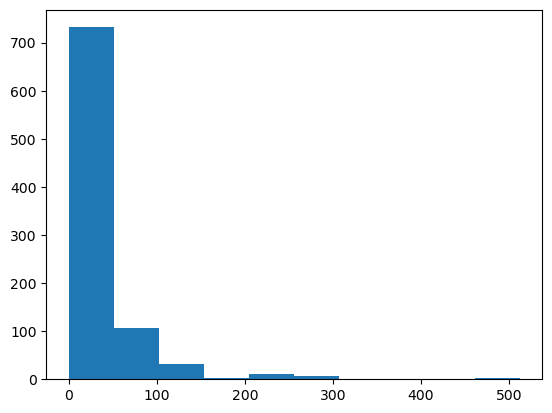

In [36]:
#fare looks interesting
plt.hist(clean_df['fare'])
plt.show()

<div class="alert alert-block alert-info">
    <b>Note</b>:
We can kind of see that <i>maybe</i> 200 or greater could be an outlier. A boxplot can show us the actual fences with its "box and whisker"
</div>

**An easy way to visualize your IQR is a boxplot!**

![](iqr.png)

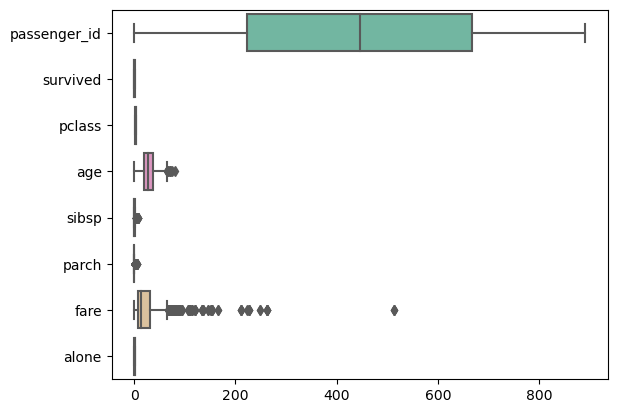

In [37]:
#take a look at our data
ax = sns.boxplot(data=clean_df, orient="h", palette="Set2")

<div class="alert alert-block alert-info">
    <b>Note</b>:
The histogram led us to believe that over 200 could be an outlier, but it turns out that the outliers begin around 100.</div>

fare outliers


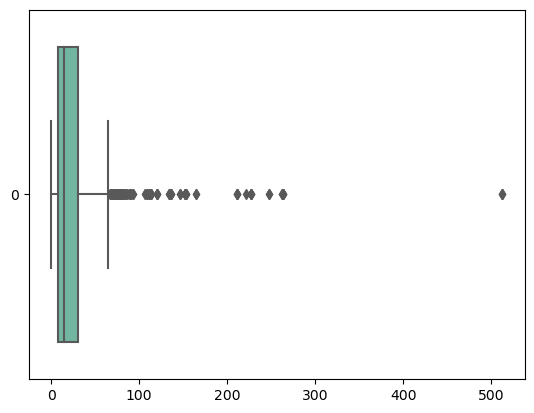

age outliers


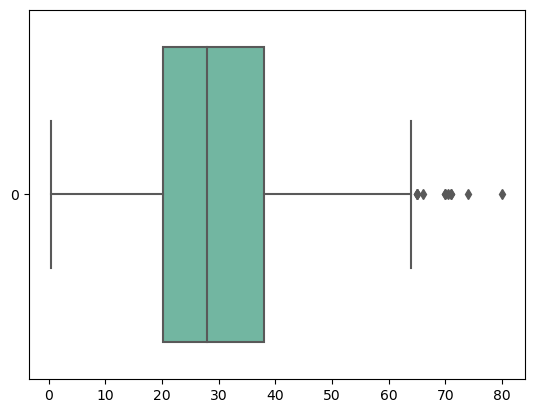

In [38]:
#specifically look at fare
ax = sns.boxplot(data=clean_df.fare, orient="h", palette="Set2")
print('fare outliers')
plt.show()

#specifically look at age
ax = sns.boxplot(data=clean_df.age, orient="h", palette="Set2")
print('age outliers')
plt.show()

<hr style="border:2px solid gray">

<b>Vocab for Overview:</b>

- Euclidean Distance- straight line
- Manhattan Distance- how do we move alone the axis to get to my point (up or down, not diagnal)
- Epsilon: distance from core point
- minPoints: how many points need to be included for it to be considered a cluster